### Problema
La empresa puede estar comprando demasiado de algunos productos que casi no se venden y poco de los que más se venden.

---

### Solucion
La solución propuesta consiste en implementar un sistema de análisis de datos que permita:
- Identificar los productos más vendidos y los que permanecen estancados en el inventario.  
- Analizar la frecuencia de compra y las ciudades o regiones con mayor concentración de ventas.  
- Generar alertas y recomendaciones automáticas para reorganizar el inventario, optimizar las compras y reducir pérdidas económicas.

--- 

### Análisis de la Base de Datos
A partir de la base de datos otorgada, se realizó la limpieza y una mejor estructura: 
- **Tabla Cliente**
    Completamente correcta, sin datos duplicados.
- **Tabla Producto**
    A partir de la columna categoria se realizo una nueva tabla llamada ```Categoria``` con las columnas: ```id_categoria``` y ```nombre_categoria```, a continuación se realizó la conexión con la tabla Producto a partir del id_categoria
- **Tabla Ventas**
    Se eliminaron las columnas ```nombre_cliente```, ```email``` y ```medio_pago```. La columna```medio pago``` paso a ser una nueva tabla, en la cual contiene ```id_medio_pago``` y ```nombre_medio_pago```.
- **Tabla Detalles_ventas**
    Se eliminaron las columnas ```nombre_producto``` y  ```precio_unitario```.

Las tablas con las que nos quedamos son: ```Cliente```, ```Producto```, ```Ventas```, ```Detalles_ventas```, ```Categoria``` y ```Metodo_Pago```.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Leer datos de todas las tablas
df_clientes = pd.read_excel('data/Clientes.xlsx')               # Tabla Clientes
df_ventas = pd.read_excel('data/Ventas.xlsx')                   # Tabla Ventas
df_productos = pd.read_excel('data/Productos.xlsx')             # Tabla Productos
df_detalle_ventas = pd.read_excel('data/Detalle_ventas.xlsx')   # Tabla Detalle_Ventas
df_categoria = pd.read_excel('data/Categorias.xlsx')             # Tabla Categoria
df_metodos_pago = pd.read_excel('data/Metodo_Pago.xlsx')    # Tabla Metodos_de_Pago

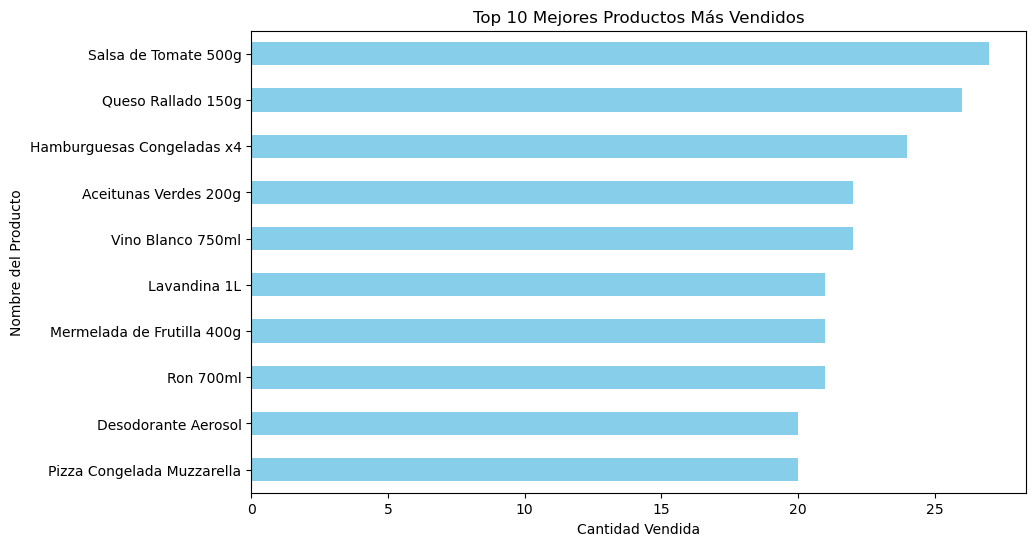

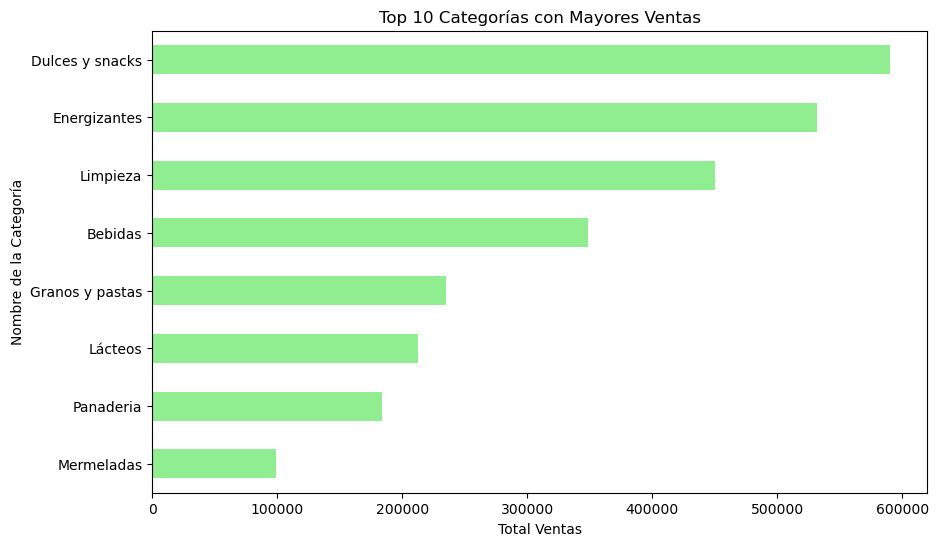

In [6]:
# Unir tablas para análisis
df_ventas_productos = df_detalle_ventas.merge(
    df_ventas, on='id_venta', how='left'
).merge(
    df_productos, on='id_producto', how='left'
)

# Top 10 mejores productos mas vendidos. Eje x: cantidad vendida, eje y: nombre del producto
top_productos = df_ventas_productos.groupby('nombre_producto')['cantidad'].sum().nlargest(10)
plt.figure(figsize=(10, 6))
top_productos.plot(kind='barh', color='skyblue')
plt.xlabel('Cantidad Vendida')
plt.ylabel('Nombre del Producto')
plt.title('Top 10 Mejores Productos Más Vendidos')
plt.gca().invert_yaxis()  # Invertir el eje y para que el
plt.show()

# Top 10 categorias con mayores ventas. Eje x: total ventas, eje y: nombre de la categoria
df_ventas_productos = df_ventas_productos.merge(
    df_categoria, on='id_categoria', how='left')
top_categorias = df_ventas_productos.groupby('nombre_categoria')['importe'].sum().nlargest(10)
plt.figure(figsize=(10, 6))
top_categorias.plot(kind='barh', color='lightgreen')
plt.xlabel('Total Ventas')
plt.ylabel('Nombre de la Categoría')
plt.title('Top 10 Categorías con Mayores Ventas')
plt.gca().invert_yaxis() 
plt.show()


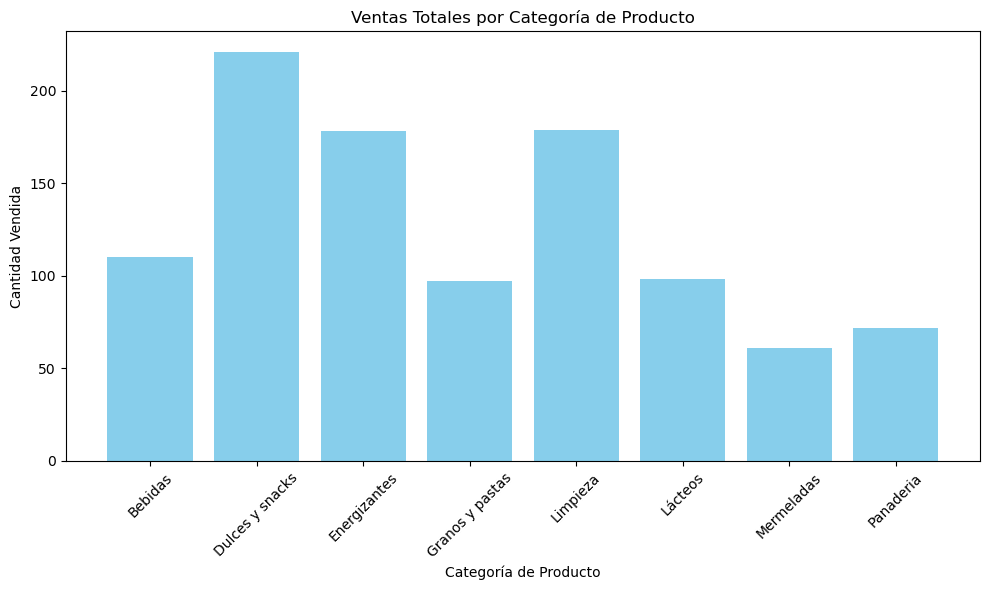

In [11]:
# Unir tablas para análisis
detalle_ventas_con_cliente = df_detalle_ventas.merge(
    df_ventas, on='id_venta', how='left'
).merge(
    df_clientes, on='id_cliente', how='left'
).merge(
    df_productos, on='id_producto', how='left'
).merge(
    df_categoria, on="id_categoria", how='left'
)
#print(detalle_ventas_con_cliente.head())
# Análisis: Ventas totales por categoría de producto
ventas_por_categoria = detalle_ventas_con_cliente.groupby('nombre_categoria')['cantidad'].sum().reset_index()
#print(ventas_por_categoria)
# Visualización: Ventas por categoría
plt.figure(figsize=(10, 6))
plt.bar(ventas_por_categoria['nombre_categoria'], ventas_por_categoria['cantidad'], color='skyblue')
plt.xlabel('Categoría de Producto')
plt.ylabel('Cantidad Vendida')
plt.title('Ventas Totales por Categoría de Producto')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

             nombre_producto  cantidad
5             Alfajor Triple         2
20  Chocolate con Leche 100g         2
25  Detergente Líquido 750ml         2
33       Galletitas Vainilla         2
54          Maní Salado 200g         3
59            Miel Pura 250g         3
94        Yogur Natural 200g         3
68       Porotos Negros 500g         3
53              Manteca 200g         4
27      Empanadas Congeladas         4


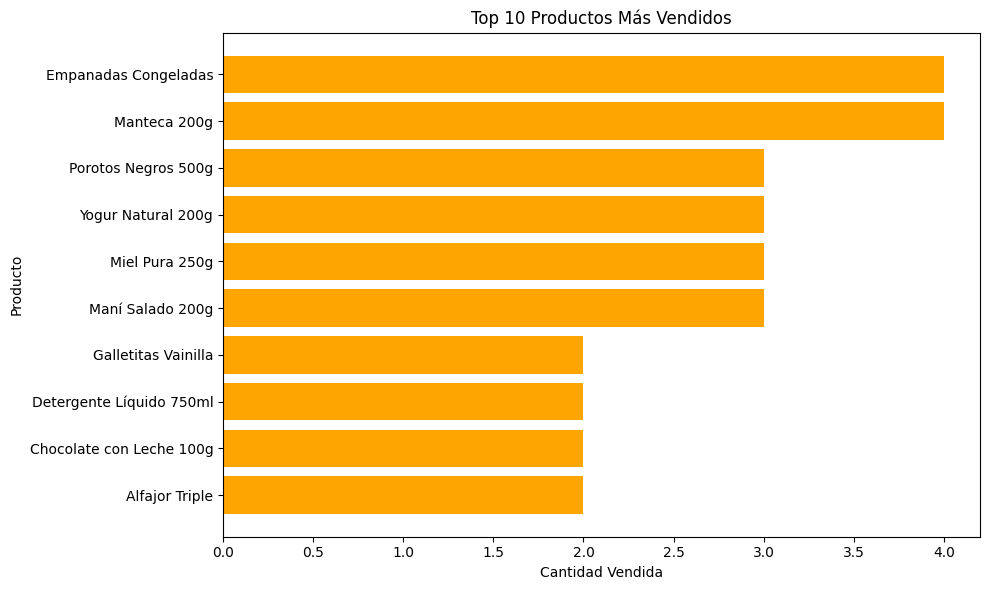

In [ ]:
# Diagrama de dispersión de la fecha con respecto a los productos (top N)
# Usamos `detalle_ventas_con_cliente` que contiene `fecha`, `nombre_producto` y `cantidad`
import numpy as np
# Preparar datos
detalle = detalle_ventas_con_cliente.copy()
# Intentar normalizar/parsear la columna de fecha (ajusta el nombre si tu columna es distinta)
if 'fecha' in detalle.columns:
    detalle['fecha'] = pd.to_datetime(detalle['fecha'], errors='coerce')
else:
    # Si la columna tiene otro nombre, descomenta y ajusta: detalle['fecha'] = pd.to_datetime(detalle['fecha_venta'])
    raise KeyError('No se encontró la columna "fecha" en `detalle_ventas_con_cliente`.')
# Filtrar filas válidas
detalle = detalle.dropna(subset=['fecha', 'nombre_producto'])
# Seleccionar top N productos por cantidad total para claridad en la visualización
top_n = 10
top_products = detalle.groupby('nombre_producto')['cantidad'].sum().nlargest(top_n).index.tolist()
detalle_top = detalle[detalle['nombre_producto'].isin(top_products)].copy()
# Mapear productos a posiciones numéricas para el eje Y (ordenados para lectura)
productos = list(top_products[::-1])
pos_map = {p: i for i, p in enumerate(productos)}
detalle_top['y_pos'] = detalle_top['nombre_producto'].map(pos_map)
# Añadir pequeño 'jitter' aleatorio en Y para evitar sobreposición
np.random.seed(0)
detalle_top['y_jitter'] = detalle_top['y_pos'] + (np.random.randn(len(detalle_top)) * 0.12)
# Dibujar scatter: X=fecha, Y=producto (jitter), tamaño = cantidad
plt.figure(figsize=(12, 6))
sizes = (detalle_top['cantidad'].fillna(1).astype(float)) ** 0.9  # escalar tamaños
plt.scatter(detalle_top['fecha'], detalle_top['y_jitter'], s=sizes * 12,
            c=detalle_top['y_pos'], cmap='tab10', alpha=0.6, edgecolor='w', linewidth=0.3)
plt.yticks(list(range(len(productos))), productos)
plt.xlabel('Fecha')
plt.ylabel(f'Producto (Top {top_n})')
plt.title('Diagrama de dispersión: ventas por fecha para productos más vendidos (size = cantidad)')
plt.grid(axis='x', alpha=0.25)
# Preparar y superponer líneas de tendencia mensuales para cada producto (normalizadas)
detalle_top['month'] = detalle_top['fecha'].dt.to_period('M').dt.to_timestamp()
monthly = detalle_top.groupby(['month', 'nombre_producto'])['cantidad'].sum().reset_index()
for p in productos:
    dfp = monthly[monthly['nombre_producto'] == p].sort_values('month')
    if dfp.empty:
        continue
    # Normalizar la serie para que la línea sea visible alrededor de la posición Y del producto
    q = dfp['cantidad'].astype(float)
    if q.max() - q.min() > 0:
        norm = (q - q.min()) / (q.max() - q.min())
    else:
        norm = q * 0.0
    # Escalar la normalización para que la línea se muestre en un rango pequeño alrededor de y_pos
    amplitude = 0.35
    y_line = pos_map[p] + (norm - 0.5) * amplitude
    plt.plot(dfp['month'], y_line, color='k', linewidth=1, alpha=0.9)
# Mostrar figura
plt.tight_layout()
plt.show()

In [ ]:
estadisticas_por_ciudad = (
    detalle_ventas_con_cliente
    .groupby(['ciudad', 'nombre_producto'])['cantidad']
    .agg(['sum', 'mean', 'median', 'var', 'std'])
    .reset_index()
)

print(estadisticas_por_ciudad.sort_values(by=['sum'], ascending=False))

          ciudad             nombre_producto  sum      mean  median       var  \
120      Cordoba           Vino Blanco 750ml   16  4.000000     4.0  1.333333   
16   Alta Gracia  Hamburguesas Congeladas x4   14  4.666667     5.0  0.333333   
31   Alta Gracia  Mermelada de Frutilla 400g   11  3.666667     3.0  1.333333   
165   Rio Cuarto       Chocolate Amargo 100g   11  3.666667     3.0  1.333333   
58    Carlos Paz         Desodorante Aerosol   11  3.666667     4.0  0.333333   
..           ...                         ...  ...       ...     ...       ...   
207   Rio Cuarto           Vino Blanco 750ml    1  1.000000     1.0       NaN   
209   Rio Cuarto                Whisky 750ml    1  1.000000     1.0       NaN   
233  Villa Maria      Sopa Instantánea Pollo    1  1.000000     1.0       NaN   
234  Villa Maria               Trapo de Piso    1  1.000000     1.0       NaN   
235  Villa Maria        Té Verde 20 saquitos    1  1.000000     1.0       NaN   

          std  
120  1.1547